In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

from model_SARIMA import find_SARIMA, build_SARIMA, SARIMA_for_all_stores
from model_naiv import build_naive_model, naive_for_all_stores

from test_mean import t_test, wilcoxon_test, binomial_test, kolmogorov_test
from test_correlation import residual_plot, acf_resid_plot, box_pierce_test, ljung_box_test, durbin_watson_test, breusch_godfrey_test, run_test

from cross_validation import cv_SARIMA_all_stores, cv_naive_all_stores

warnings.filterwarnings("ignore")

/Users/alex/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Datensatz lesen

In [2]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

Alle Residuen und Fitted Values berechnen

In [3]:
#residuals_dict = naive_for_all_stores('Walmart_Sales.csv')

fitted_values_dict = {}
residuals_dict = {}

sarima_models = SARIMA_for_all_stores('Walmart_Sales.csv', whichorder = 5)
for store in range(1, 46):
    model = sarima_models.get(store)
    
    fitted_values_dict[store] = model.fittedvalues.iloc[1:] # remove first value because it is 0
    residuals_dict[store] = model.resid.iloc[1:] # remove first value because it is 0


Store 1: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 2: Modell erstellt mit Order (4, 0, 3) und Seasonal Order (1, 0, 1, 52)
Store 3: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (2, 0, 0, 52)
Store 4: Modell erstellt mit Order (2, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 5: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 6: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 7: Modell erstellt mit Order (0, 1, 1) und Seasonal Order (0, 1, 0, 52)
Store 8: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 9: Modell erstellt mit Order (1, 1, 1) und Seasonal Order (1, 0, 0, 52)
Store 10: Modell erstellt mit Order (4, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 11: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 12: Modell erstellt mit Order (2, 0, 2) und Seasonal Order (1, 0, 0, 52)
Store 13: Modell erstellt mit Order (2, 0, 2) und Seasonal Or

Residuen

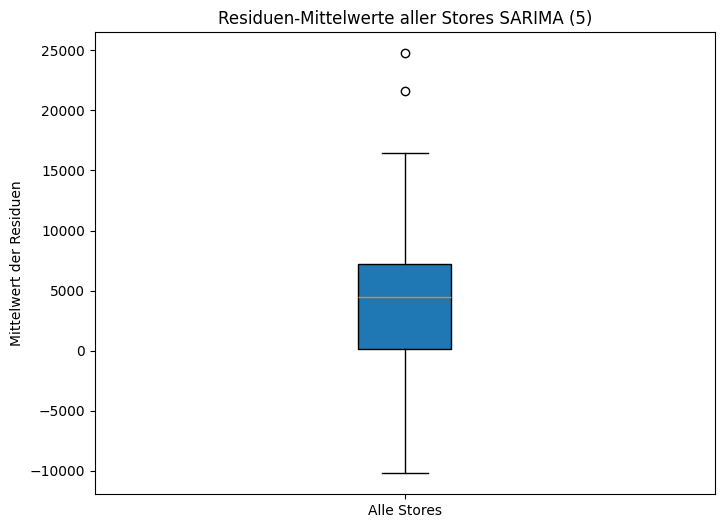

In [12]:
store_means = []
for store in sorted(residuals_dict.keys(), key=int):
    mean_resid = residuals_dict[store].mean()
    store_means.append(mean_resid)

# Erstelle den Boxplot der Mittelwerte
plt.figure(figsize=(8, 6))
plt.boxplot(store_means, patch_artist=True)
plt.title("Residuen-Mittelwerte aller Stores SARIMA (5)")
plt.ylabel("Mittelwert der Residuen")
plt.xticks([1], ["Alle Stores"])
plt.show()

Korrelations Tests

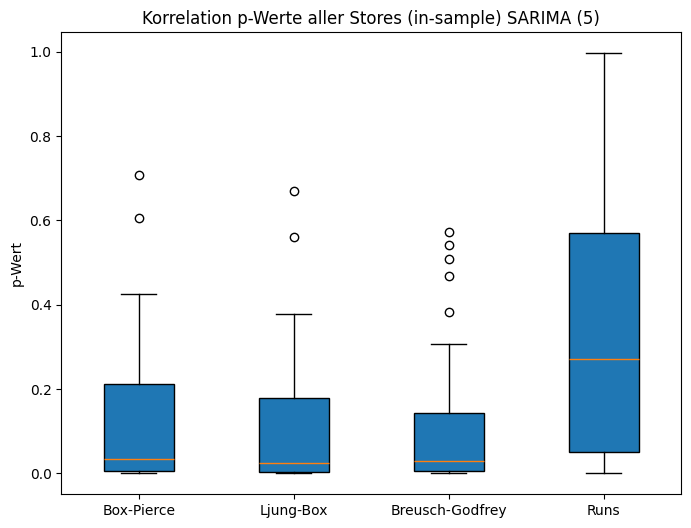

In [13]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(resid, False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(resid, False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(resid, False, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(resid, False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Korrelation p-Werte aller Stores (in-sample) SARIMA (5)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()

Durbin Watson

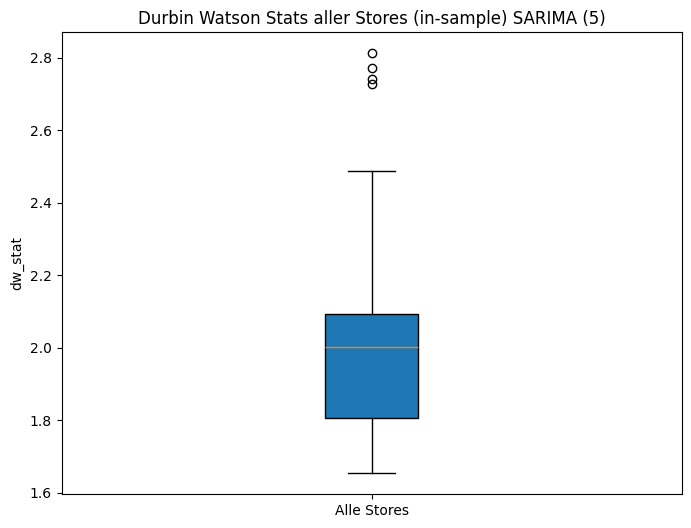

In [14]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(resid, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True)
plt.title("Durbin Watson Stats aller Stores (in-sample) SARIMA (5)")
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

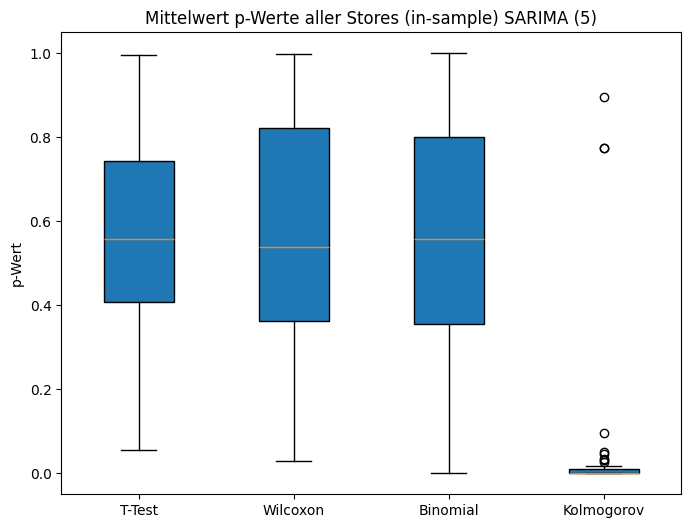

In [15]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    resid = residuals_dict.get(store)
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(resid, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(resid, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(resid, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(resid, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Mittelwert p-Werte aller Stores (in-sample) SARIMA (5)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()

Kreuzvalidierung

In [8]:
cvs = cv_SARIMA_all_stores('Walmart_Sales.csv', order = 5)
#cvs = cv_naive_all_stores('Walmart_Sales.csv')

Verarbeite Store 1 (Datenlänge: 143)...
Cross-Validation RMSE: 88027.56322355426
Verarbeite Store 2 (Datenlänge: 143)...
Cross-Validation RMSE: 89491.95798082574
Verarbeite Store 3 (Datenlänge: 143)...
Cross-Validation RMSE: 25549.247914828426
Verarbeite Store 4 (Datenlänge: 143)...
Cross-Validation RMSE: 83659.57640382502
Verarbeite Store 5 (Datenlänge: 143)...
Cross-Validation RMSE: 18367.25093480805
Verarbeite Store 6 (Datenlänge: 143)...
Cross-Validation RMSE: 89097.7718419471
Verarbeite Store 7 (Datenlänge: 143)...
Cross-Validation RMSE: 34468.4848204033
Verarbeite Store 8 (Datenlänge: 143)...
Cross-Validation RMSE: 39873.25790930332
Verarbeite Store 9 (Datenlänge: 143)...
Cross-Validation RMSE: 30580.994522736946
Verarbeite Store 10 (Datenlänge: 143)...
Cross-Validation RMSE: 95521.02327787026
Verarbeite Store 11 (Datenlänge: 143)...
Cross-Validation RMSE: 75092.85320127761
Verarbeite Store 12 (Datenlänge: 143)...
Cross-Validation RMSE: 48835.193033167
Verarbeite Store 13 (Datenl

Korrelations Test

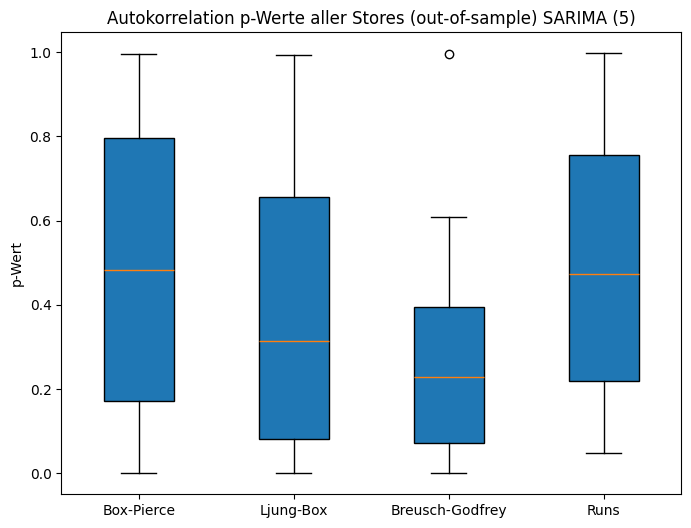

In [16]:
bp_pvalues = []
lb_pvalues = []
bg_pvalues = []
rt_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if errors is not None:
        # Box-Pierce Test
        try:
            _, p_value = box_pierce_test(errors, False)
            bp_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Box-Pierce Test für Store {store}: {e}")
            bp_pvalues.append(np.nan)
        # Ljung-Box Test
        try:
            _, p_value = ljung_box_test(errors, False)
            lb_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Ljung-Box Test für Store {store}: {e}")
            lb_pvalues.append(np.nan)
        # Breusch-Godfrey Test
        try:
            _, p_value = breusch_godfrey_test(errors, False, lags=10)
            bg_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Breusch-Godfrey Test für Store {store}: {e}")
            bg_pvalues.append(np.nan)
        # Runs Test
        try:
            _, p_value = run_test(errors, False)
            rt_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Runs Test für Store {store}: {e}")
            rt_pvalues.append(np.nan)
    else:
        bp_pvalues.append(np.nan)
        lb_pvalues.append(np.nan)
        bg_pvalues.append(np.nan)
        rt_pvalues.append(np.nan)


pvalues = np.column_stack([bp_pvalues, lb_pvalues, bg_pvalues, rt_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Autokorrelation p-Werte aller Stores (out-of-sample) SARIMA (5)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["Box-Pierce", "Ljung-Box", "Breusch-Godfrey", "Runs"])
plt.show()



Durbin Watson

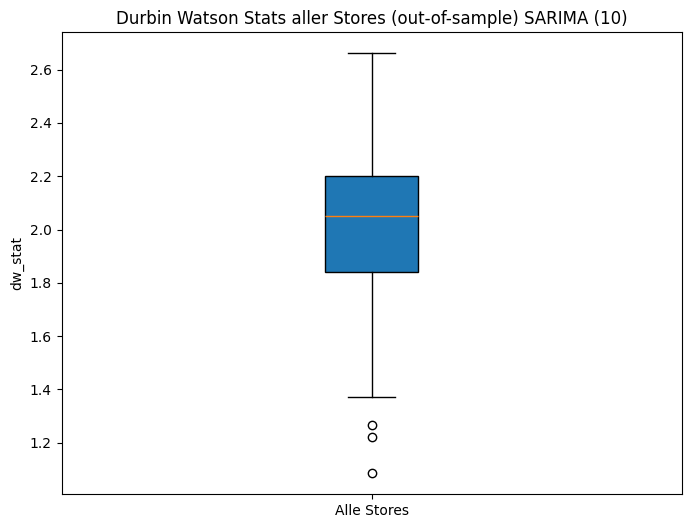

In [ ]:
dw_stats = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    error = cvs[cvs['store'] == store]['error']
    if resid is not None:
        try:
            dw_stat = durbin_watson_test(error, False)
            dw_stats.append(dw_stat)
        except Exception as e:
            print(f"Fehler beim Durbin Watson Test für Store {store}: {e}")
            dw_stats.append(np.nan)
    else:
        dw_stats.append(np.nan)

# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(dw_stats, patch_artist=True)
plt.title("Durbin Watson Stats aller Stores (out-of-sample) SARIMA (5)")
plt.ylabel("dw_stat")
plt.xticks([1], ["Alle Stores"])
plt.show()


Mittelwert Tests

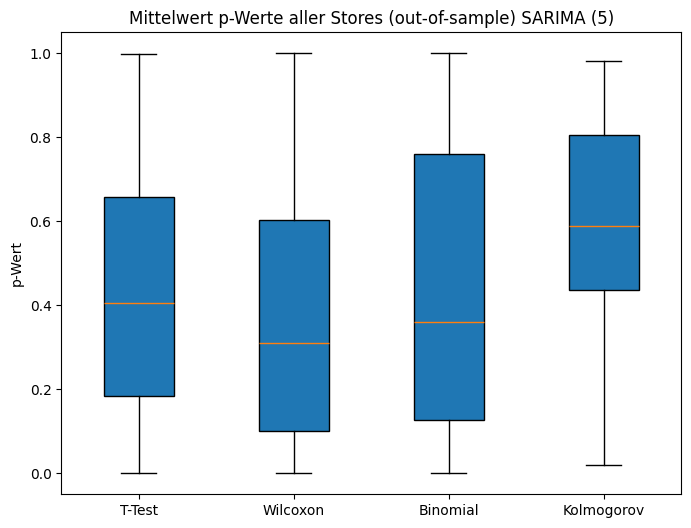

In [17]:
t_pvalues = []
w_pvalues = []
b_pvalues = []
k_pvalues = []

# Für jeden Store von 1 bis 45:
for store in range(1, 46):
    errors = cvs[cvs['store'] == store]['error']
    if resid is not None:
        # T-Test
        try:
            _, p_value = t_test(errors, False)
            t_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim t-Test für Store {store}: {e}")
            t_pvalues.append(np.nan)
        # Wilcoxon Test
        try:
            _, p_value = wilcoxon_test(errors, False)
            w_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Wilcoxon Test für Store {store}: {e}")
            w_pvalues.append(np.nan)
        # Binomial Test
        try:
            _, _, p_value = binomial_test(errors, False)
            b_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Binomial Test für Store {store}: {e}")
            b_pvalues.append(np.nan)
        # Kolmogorov Test
        try:
            _, p_value = kolmogorov_test(errors, False)
            k_pvalues.append(p_value)
        except Exception as e:
            print(f"Fehler beim Kolmogorov Test für Store {store}: {e}")
            k_pvalues.append(np.nan)
    else:
        t_pvalues.append(np.nan)
        w_pvalues.append(np.nan)
        b_pvalues.append(np.nan)
        k_pvalues.append(np.nan)


pvalues = np.column_stack([t_pvalues, w_pvalues, b_pvalues, k_pvalues])


# Erstelle einen Boxplot der p-Werte
plt.figure(figsize=(8, 6))
plt.boxplot(pvalues, patch_artist=True)
plt.title("Mittelwert p-Werte aller Stores (out-of-sample) SARIMA (5)")
plt.ylabel("p-Wert")
plt.xticks([1, 2, 3, 4], ["T-Test", "Wilcoxon", "Binomial", "Kolmogorov"])
plt.show()

